<p align="center">
<strong>CVSN Assignment-2</strong>  
<br>
<strong>Mayank Nagar</strong>  
<br>
<strong>MDS202334</strong>  
</p>

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

# Question-1

In [2]:
img1 = cv.imread('./images/image1.jpg')
img2 = cv.imread('./images/image2.jpg')

assert img1 is not None
assert img2 is not None

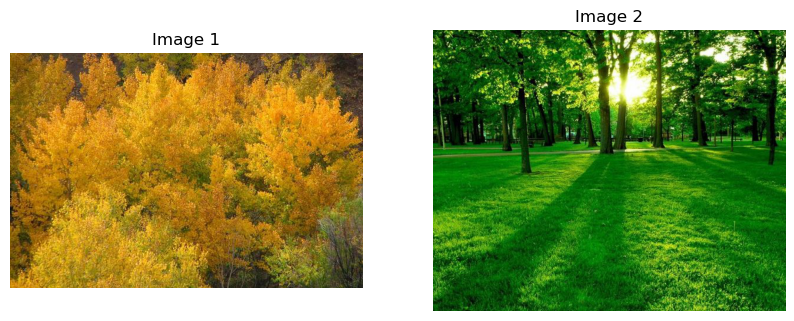

In [3]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img1[:,:,::-1])
plt.title('Image 1')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2[:,:,::-1])
plt.title('Image 2')
plt.axis('off')

plt.show()

### (a) Histograms of each channel of Image-1

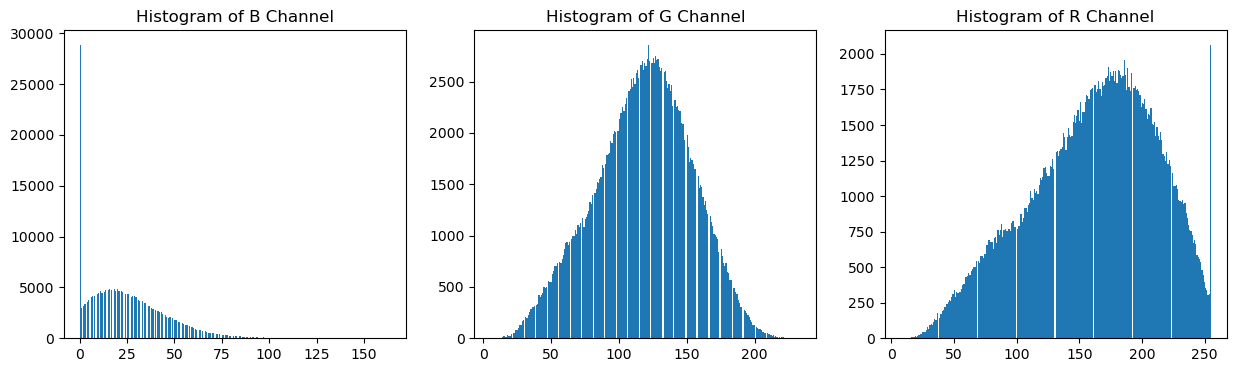

In [4]:
plt.figure(figsize=(15,4))
for i, channel in enumerate(['B', 'G', 'R']):
    plt.subplot(1,3,i+1)
    plt.title(f'Histogram of {channel} Channel')
    plt.hist(img1[:,:,i].ravel(), bins=256, fc='k', ec='k')
plt.show()

### Histograms of each channel of Image-2

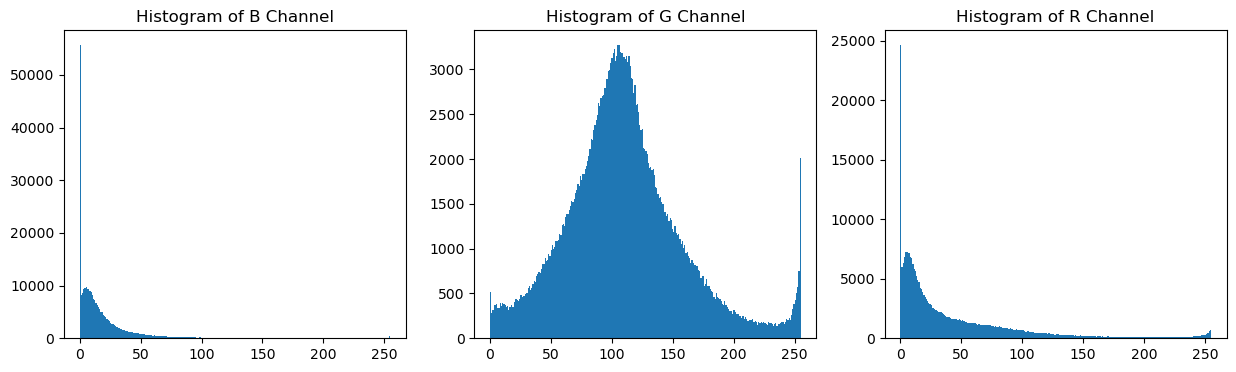

In [5]:
plt.figure(figsize=(15,4))
for i, channel in enumerate(['B', 'G', 'R']):
    plt.subplot(1,3,i+1)
    plt.title(f'Histogram of {channel} Channel')
    plt.hist(img2[:,:,i].ravel(), bins=256, fc='k', ec='k')
plt.show()

### (b) Histogram Matching

In [6]:
def histogram_matching(source, reference):
    # Placeholder
    transformed_img = np.zeros_like(source, dtype=np.uint8)

    # Equalize both images
    he1 = cv.equalizeHist(source)
    he2 = cv.equalizeHist(reference)

    # Transformation Functions 
    Tr = {r: tr for r, tr in zip(source.ravel(), he1.ravel())}
    Gz = {z: gz for z, gz in zip(reference.ravel(), he2.ravel())}
    Gz_inv = defaultdict(set)
    for z, gz in Gz.items():
        Gz_inv[gz].add(z)

    # Histogram matching function
    mapping = {}
    for i in range(256):
        v = None
        if i in Tr:
            v = Tr[i]
        else:
            continue

        if v in Gz_inv:
            mapping[i] = list(Gz_inv[v])[0]
        else:
            l = 0
            while v - l >= 0 or v + l <= 255:
                if v - l in Gz_inv and v + l in Gz_inv:
                    mapping[i] = min(Gz_inv[v-l]) # I choose to go with min value
                    break
                elif v - l in Gz_inv:
                    mapping[i] = min(Gz_inv[v-l])
                    break
                elif v + l in Gz_inv:
                    mapping[i] = min(Gz_inv[v+l])
                    break
                else:
                    l += 1
                
    # Matching the source image to reference
    for i in range(source.shape[0]):
        for j in range(source.shape[1]):
            transformed_img[i, j] = mapping[source[i, j]]
            
    return mapping, transformed_img

In [7]:
# Applying the histogram matching function
transformed_img = np.zeros_like(img1, dtype=np.uint8)
for channel in range(3):
    mapping, matched_channel = histogram_matching(img1[:,:,channel], img2[:,:,channel])
    transformed_img[:,:,channel] = matched_channel

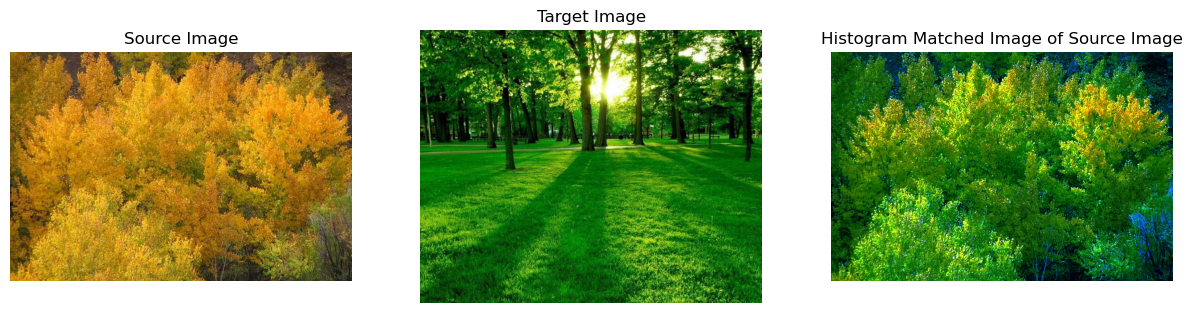

In [8]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(img1[:,:,::-1])
plt.title('Source Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img2[:,:,::-1])
plt.title('Target Image')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(transformed_img[:,:,::-1])
plt.title('Histogram Matched Image of Source Image')
plt.axis('off')

plt.show()

The reconstructed image appears greenish because the target image contains a high concentration of green pixels.

# Question-2

### (a) Experimenting with different clip limits in contrast limited AHE

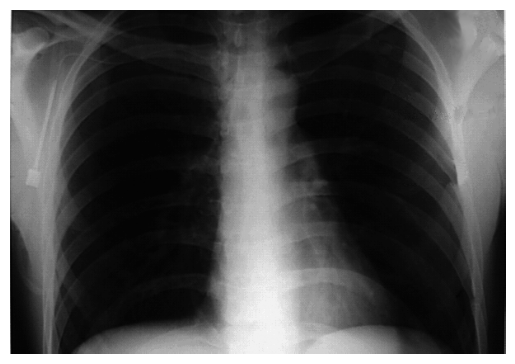

In [9]:
xray = cv.imread('./images/chestxray1.png', 0)
assert xray is not None

plt.imshow(xray, cmap='gray')
plt.axis('off')
plt.show()

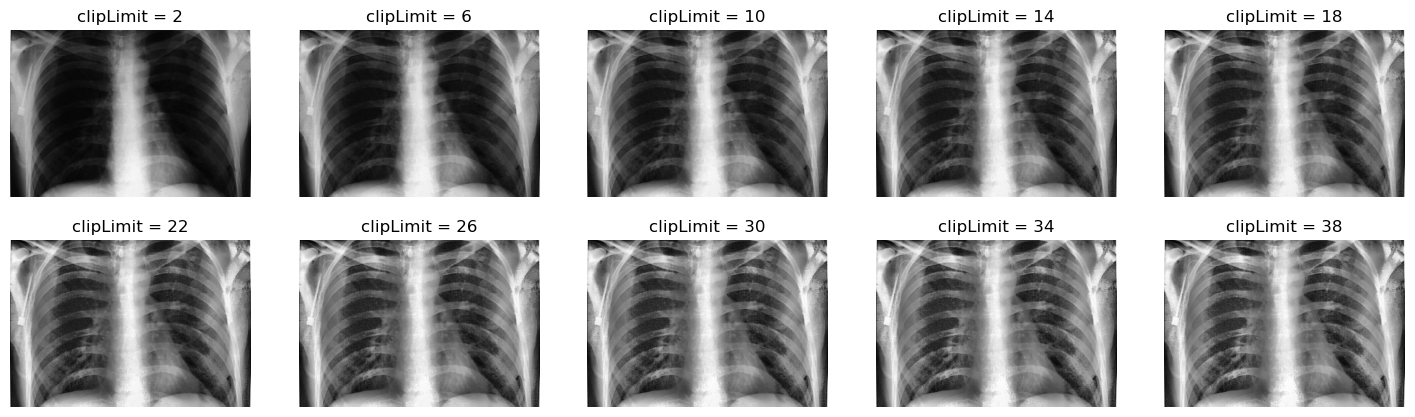

In [10]:
plt.figure(figsize= (18, 5))
for i, clipLimit in enumerate(range(2,41,4)):
    clahe = cv.createCLAHE(clipLimit=clipLimit)
    plt.subplot(2, 5, i+1)
    img = clahe.apply(xray)
    plt.imshow(img, cmap='gray')
    plt.title(f"{clipLimit = }")
    plt.axis('off')

As we increase `clipLimit` value contrast increases

### (b) Implementation of Sliding Window AHE

In [11]:
def SWAHE(image, k):
    h, w = image.shape
    pad = k // 2
    swahe_image = np.zeros_like(image)

    # Pad the image to handle border effects
    padded_image = np.pad(image, pad, mode='reflect')

    # Extract the k×k window centered at each pixel
    for y in range(h):
        for x in range(w):
            window = padded_image[y:y + k, x:x + k]

            # Equalize window
            equalized_window = cv.equalizeHist(window)
            
            # Map pixel intensity using the computed CDF
            swahe_image[y, x] = equalized_window[pad, pad]
    
    return swahe_image

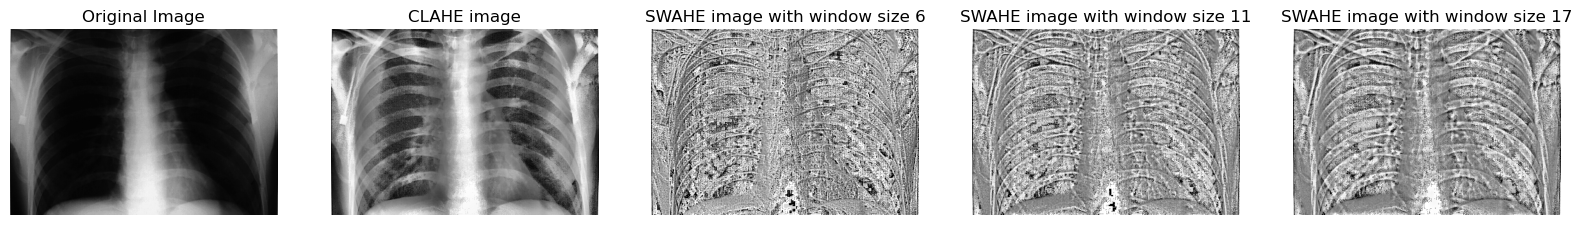

In [12]:
# Display the results
plt.figure(figsize=(20, 10))
plt.subplot(1, 5, 1)
plt.imshow(xray, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 5, 2)
clahe = cv.createCLAHE(clipLimit=38)
clahe_image = clahe.apply(xray)
plt.imshow(clahe_image, cmap='gray')
plt.title("CLAHE image")
plt.axis("off")

for i, k in enumerate([6,11,17]):
    plt.subplot(1, 5, i+3)
    swahe_image = SWAHE(xray, k)
    plt.imshow(swahe_image, cmap='gray')
    plt.title(f"SWAHE image with window size {k}")
    plt.axis("off")
plt.show()

`CLAHE` enhances the image contrast, but the center (spine) remains overly bright, making it difficult to see details. This issue is resolved by using the `SWAHE` technique, where windowed histogram equalization ensures more uniform brightness.  

When comparing output images from `SWAHE`, increasing the `window size` improves clarity, making all artifacts more distinguishable.

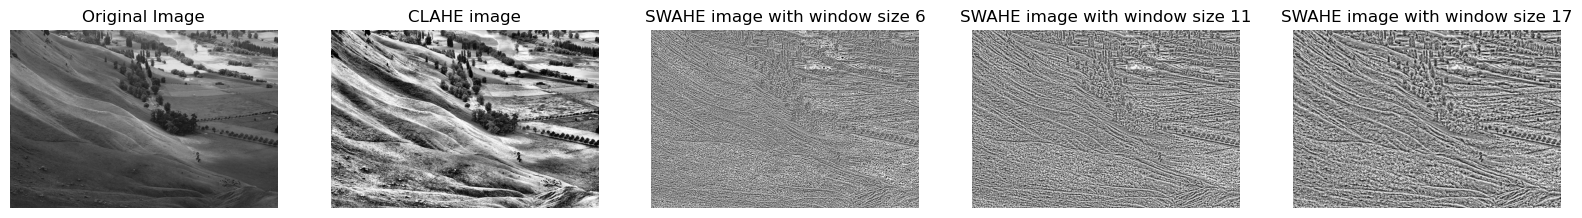

In [13]:
wiki = cv.imread('images/Unequalized_Hawkes_Bay_NZ.jpg', 0)

# Display the results
plt.figure(figsize=(20, 10))
plt.subplot(1, 5, 1)
plt.imshow(wiki, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 5, 2)
clahe = cv.createCLAHE(clipLimit=38)
clahe_image = clahe.apply(wiki)
plt.imshow(clahe_image, cmap='gray')
plt.title("CLAHE image")
plt.axis("off")

for i, k in enumerate([6,11,17]):
    plt.subplot(1, 5, i+3)
    swahe_image = SWAHE(wiki, k)
    plt.imshow(swahe_image, cmap='gray')
    plt.title(f"SWAHE image with window size {k}")
    plt.axis("off")
plt.show()

In this example of the `CLAHE` contrast of the image increases and the image becomes clearer. But in the case of the `SWAHE`, it introduces noise.

### (d) Observations about when each method may be preferable

| Feature             | **CLAHE** | **SWAHE** |
|---------------------|--------------------------------|-------------------------------|
| **Noise Handling**  | **Reduces noise** by clipping histogram peaks | Can amplify noise, especially in flat regions |
| **Computation Speed** | Faster | Slower (Window-based operations are computationally expensive) |
| **Contrast Adjustment** | Controlled contrast (via `clipLimit`) | Can over-enhance contrast in some areas |
| **Edge Preservation** | Better at preserving edges | May introduce artifacts at strong edges |


# Question-3

### Function for intensity slicing

In [14]:
def intensity_slicing(img, min_range, max_range, method='zero'):
    output = img.copy()
    if method == 'zero':
        output[(min_range >= img) | (img >= max_range)] = 0
        output[(min_range < img) & (img < max_range)] = 255
    elif method == 'unchanged':
        output[(min_range < img) & (img < max_range)] = 255
    else:
        raise ValueError(f'{method} is not valid')
    return output

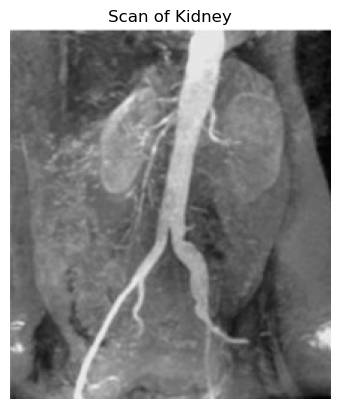

In [15]:
kidney_image = cv.imread('./images/kidney.jpg', 0)
# Display the grayscale face image
plt.imshow(kidney_image, cmap='gray')
plt.title("Scan of Kidney")
plt.axis("off")
plt.show()

### (a) highlight a particular range and set the rest to zero;
### (b) highlight a particular range and leave the rest unchanged.

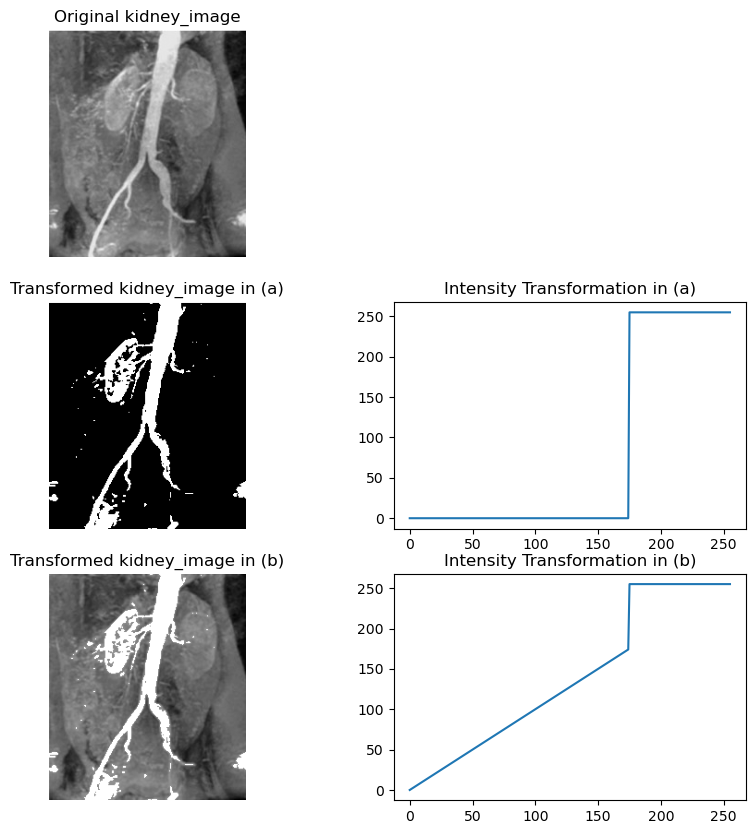

In [16]:
plt.figure(figsize=(10, 10))

plt.subplot(3,2,1)
plt.imshow(kidney_image, cmap='gray')
plt.axis('off')
plt.title('Original kidney_image')

plt.subplot(3,2,3)

low = 175
high = 255

new_img = intensity_slicing(kidney_image, low, high, method='zero')
plt.imshow(new_img, cmap='gray')
plt.title('Transformed kidney_image in (a)')
plt.axis('off')

plt.subplot(3,2,4)
plt.plot(range(256), [0]*low+[255]*(high-low+1)+[0]*(255-high))
plt.title('Intensity Transformation in (a)')

plt.subplot(3,2,5)
new_img = intensity_slicing(kidney_image, low, high, method='unchanged')
plt.title('Transformed kidney_image in (b)')
plt.imshow(new_img, cmap='gray')
plt.axis('off')

plt.subplot(3,2,6)
plt.plot(range(256), list(range(low))+[255]*(high-low+1)+list(range(high+1, 256)))
plt.title('Intensity Transformation in (b)')
plt.show()

# Question-4

### (a) Extracting and plotting all 8 bit planes

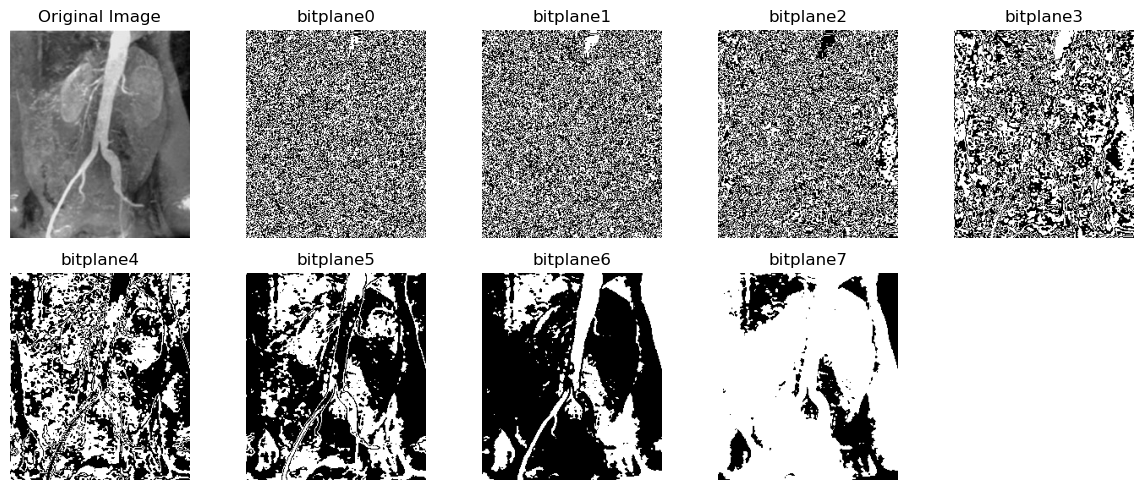

In [17]:
# Create a list to store the bit planes
bit_planes = []

# Extract each bit plane (0-7)
for i in range(8):
    # Use bitwise AND and shift to extract the i-th bit
    bit_plane = (kidney_image & (1 << i)) >> i
    bit_planes.append(bit_plane)

# Plot the original image and its bit planes
plt.figure(figsize=(12, 5))
plt.subplot(2, 5, 1)
plt.imshow(kidney_image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Plotting the bit planes
for i in range(8):
    plt.subplot(2, 5, i + 2)
    plt.imshow(bit_planes[i], cmap="gray")
    plt.title(f"bitplane{i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### (b) Plotting intensity transformations used in bitplane0, bitplane3, bitplane7

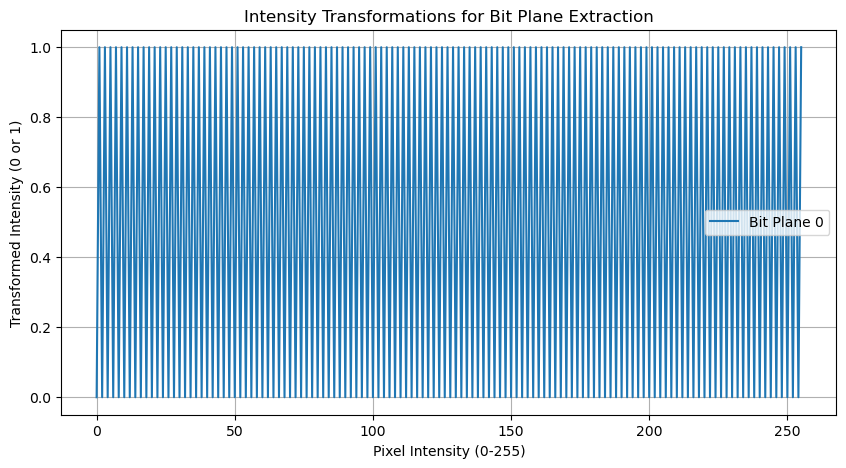

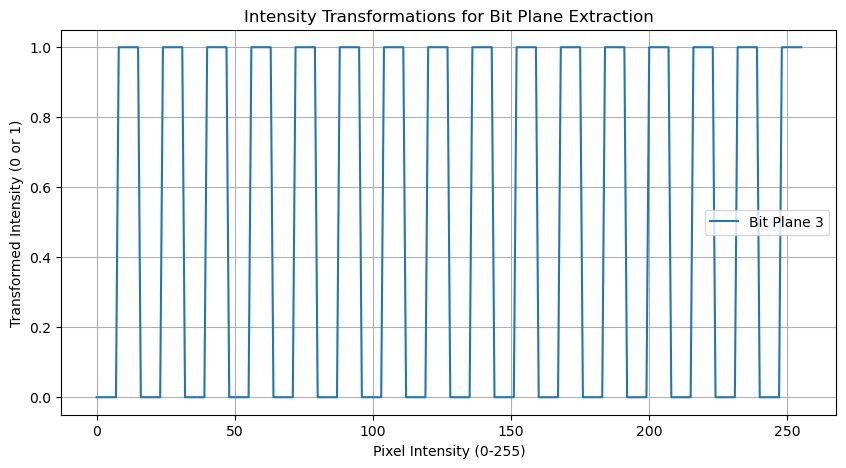

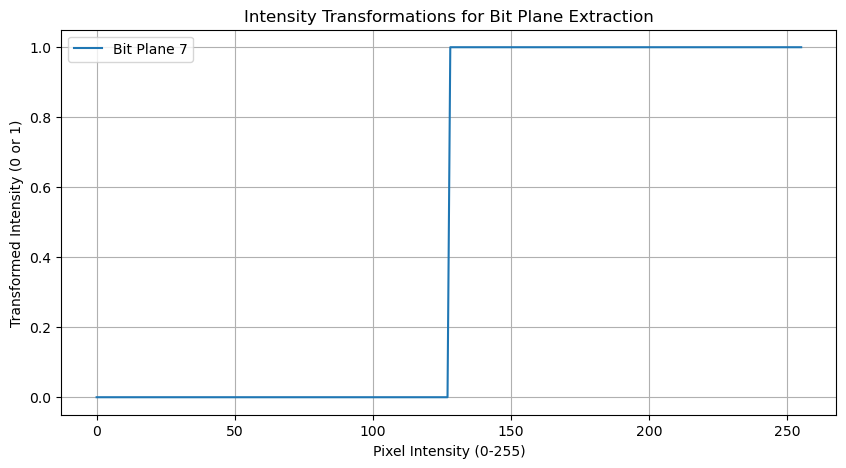

In [18]:
x_values = np.arange(256)

# Plot the transformations
for bit in [0, 3, 7]:
    plt.figure(figsize=(10, 5))

    # Compute transformations for bitplane 0, 3, and 7
    y_bitplane = (x_values & (1 << bit)) >> bit

    plt.plot(x_values, y_bitplane, label=f"Bit Plane {bit}")
    plt.xlabel("Pixel Intensity (0-255)")
    plt.ylabel("Transformed Intensity (0 or 1)")
    plt.title("Intensity Transformations for Bit Plane Extraction")
    plt.legend()
    plt.grid(True)
    plt.show()

### (c) Reconstructing the image with fewer bit planes

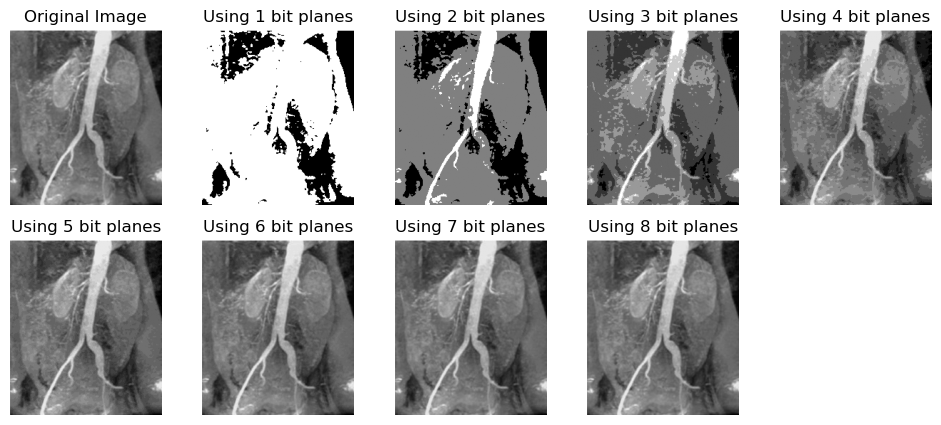

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(2, 5, 1)
plt.imshow(kidney_image, cmap="gray")
plt.title("Original Image")
plt.axis("off")


reconstructed_image = np.zeros_like(kidney_image, dtype=np.uint8)
for i in range(8):
    plt.subplot(2, 5, i+2)
    reconstructed_image = (reconstructed_image*2 + bit_planes[-i-1]).astype(np.uint8)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.axis('off')
    plt.title(f'Using {i+1} bit planes')
plt.show()

At least 5 bit planes are required to reconstruct the image without loosing too much details

# Question-5

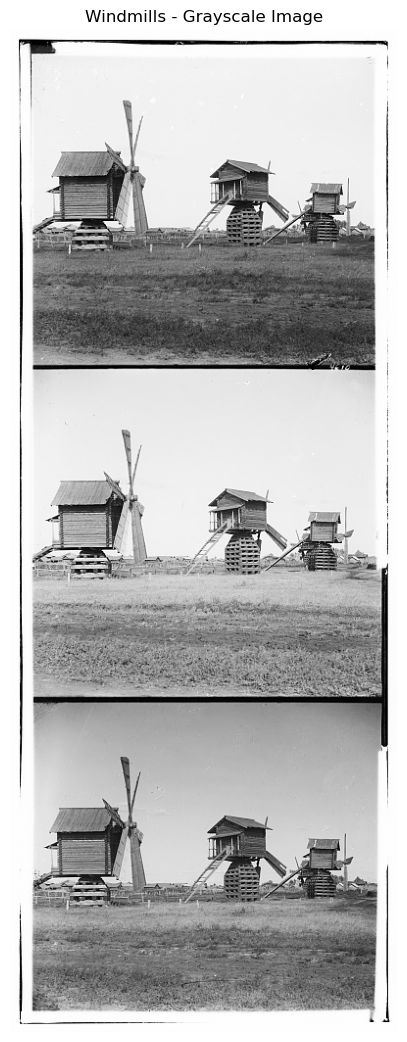

In [20]:
windmill = cv.imread('./images/windmills.jpg', 0)
assert windmill is not None

plt.figure(figsize=(5, 15))
plt.imshow(windmill, cmap='gray')
plt.title("Windmills - Grayscale Image")
plt.axis("off")
plt.show()

### (a) Computing the best alignment of two channels of windmill image 

In [21]:
def ssd(image1, image2):
    """Function to compute SSD (Sum of Squared Differences)
    """
    return np.sum((image1 - image2) ** 2)


def best_alignment(fixed, moving, search_range=10):
    """Function to find the best alignment for a channel
    """
    best_shift = (0, 0)
    min_ssd = float('inf')
    
    # Try all displacements in the given range [-search_range, search_range]
    for dx in range(-search_range, search_range + 1):
        for dy in range(-search_range, search_range + 1):
            # Shift the moving image
            shifted = np.roll(moving, (dy, dx), axis=(0, 1))
            
            # Compute SSD with the fixed image (blue channel)
            error = ssd(fixed, shifted)
            
            # Update if a better alignment is found
            if error < min_ssd:
                min_ssd = error
                best_shift = (dx, dy)

    return best_shift, min_ssd

In [22]:
height = windmill.shape[0] // 3

# Split into three channels (B, G, R)
B = windmill[0:height, :]
G = windmill[height:2*height, :]
R = windmill[2*height:3*height, :]

In [23]:
# Align Green and Red channels to the fixed Blue channel
(dx_g, dy_g), min_ssd_g = best_alignment(B, G)
(dx_r, dy_r), min_ssd_r = best_alignment(B, R)

# Apply the best shifts
aligned_G = np.roll(G, (dy_g, dx_g), axis=(0, 1))
aligned_R = np.roll(R, (dy_r, dx_r), axis=(0, 1))

### (b) Best `SSD` value and displacement vector for each channel

In [24]:
print(f'Best SSD value for Green channel {min_ssd_g}')
print(f'Displacement vector for the Green channel {(dx_g, dy_g)}')
print()
print(f'Best SSD value for Red channel {min_ssd_r}')
print(f'Displacement vector for the Red channel {(dx_r, dy_r)}')

Best SSD value for Green channel 10118958
Displacement vector for the Green channel (0, -1)

Best SSD value for Red channel 13107332
Displacement vector for the Red channel (0, 10)


### (c) Merge aligned channels into a single RGB image

In [25]:
aligned_image = np.dstack([aligned_R, aligned_G, B])

### (d) Displaying the coloured image

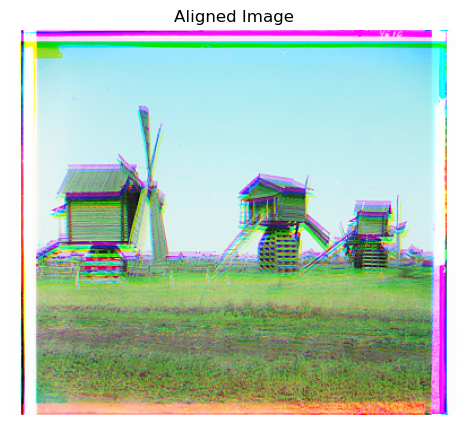

In [26]:
plt.figure(figsize=(10, 5))
plt.imshow(aligned_image)
plt.axis("off")
plt.title("Aligned Image")
plt.show()